# Food Delivery Operations Exploratory Data Analysis

In [1]:
from IPython.display import SVG, HTML

HTML('<img src="zomatoDatasetERD.svg" width="300" height="200">')

In [2]:
# Importing Dataset from Kaggle

import kagglehub
Zomato_dataset = kagglehub.dataset_download('saurabhbadole/zomato-delivery-operations-analytics-dataset')

print('Data source import complete.')

Data source import complete.


In [3]:
!pip install geopy
!pip install haversine
!pip install folium

In [4]:
# Importing all the required libraries

import numpy as np
import pandas as pd
import os
import gc
from datetime import datetime
from datetime import date as dt
import geopy.distance
import gmplot

import warnings
warnings.simplefilter(action='ignore')

#Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sborn

#Geo coding libraries
from haversine import haversine, Unit
from sklearn.cluster import DBSCAN
import json
from geopy.geocoders import Nominatim
import time

#variables
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
TIME_FORMAT = '%H:%M'
DATE_FORMAT = '%d-%m-%Y'

In [5]:
# helper function/s

# calculate time difference
def get_timediff(t1:str, t2:str):
    
    '''
    get time difference between 2 time strings
    note: assumption is that t2 is always greater !
    '''
    try:
        t1 = datetime.strptime(t1, TIME_FORMAT)
        t2 = datetime.strptime(t2, TIME_FORMAT)
        if t2 > t1:
            subtractedTime = t2 - t1
            return int(subtractedTime.total_seconds() / 60)  # conver to mins
        else:
            return None
    except:
        return None
    

# calculate distance from geo-coordinates
def get_distance(rlat:float, rlon:float, dlat:float, dlon:float):
    
    '''
    get the distance (km) between 2 geo - coordinates
    note: the argument order does not change (restaurant > delivert loc.)
    '''
    # restaurant co-ordinates
    res_coords = (abs(rlat), abs(rlon))
    
    # delivery location co-ordinates
    dl_coords = (abs(dlat), abs(dlon))
    
    # get the distance
    try:
        dist = geopy.distance.geodesic(res_coords, dl_coords).km
        return round(dist,2)             # round to nearest 2 decimals
    except:
        return None

## Data Modelling and Cleaning

In [6]:
#import csv file as a pandas data frame along with date parsing for Order_date (optimization)

csv_file_path = os.path.join(Zomato_dataset, 'Zomato Dataset.csv')
dateparse = lambda x: datetime.strptime(x, DATE_FORMAT)
df = pd.read_csv(csv_file_path, parse_dates=['Order_Date'], date_parser=dateparse)

### Data cleaning operations

In [7]:
#drop rows with null values
df.dropna(inplace=True)

# renaming columns with spaces (to avoid data type errors)
df.rename(columns={'Time_taken (min)':'Time_taken_min'}, inplace=True)

# formatting column names -- optional
df.columns = [c.lower() for c in df.columns]
          
# sorting data for visualization
df.sort_values(by=['order_date'],inplace=True)
df.reset_index(drop=True, inplace=True)

print(f"Data Shape: {df.shape}\n\n")

Data Shape: (41359, 20)




In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41359 entries, 0 to 41358
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   id                           41359 non-null  object        
 1   delivery_person_id           41359 non-null  object        
 2   delivery_person_age          41359 non-null  float64       
 3   delivery_person_ratings      41359 non-null  float64       
 4   restaurant_latitude          41359 non-null  float64       
 5   restaurant_longitude         41359 non-null  float64       
 6   delivery_location_latitude   41359 non-null  float64       
 7   delivery_location_longitude  41359 non-null  float64       
 8   order_date                   41359 non-null  datetime64[ns]
 9   time_orderd                  41359 non-null  object        
 10  time_order_picked            41359 non-null  object        
 11  weather_conditions           41359 non-nu

In [9]:
# de-duplication criteria#1 columns 
dup_c1 = ['delivery_person_id'
       ,'delivery_person_age'
       #,'delivery_location_latitude'
       #,'delivery_location_longitude'
       ,'order_date'
       ,'time_orderd']

# de-duplicate the dataset (keep = None)
df = df[~df.duplicated(subset=dup_c1, keep=False)]

### convert age into INT ###  -- optional
df['delivery_person_age'] = df['delivery_person_age'].astype(np.int64)

### Rename attributes for better understanding
df.rename(columns={'time_orderd': 'time_ordered'}, inplace=True)
df.rename(columns={'id': 'order_id'}, inplace=True)
df.rename(columns={'delivery_person_ratings': 'order_rating'}, inplace=True)

### Removing illogical coordinate values (not corresponding to Indian mainland or any viable location)
df = df[(df['restaurant_latitude'] >= 10)].reset_index(drop=True)

In [10]:
df.head()

,order_id,delivery_person_id,delivery_person_age,order_rating,restaurant_latitude,restaurant_longitude,delivery_location_latitude,delivery_location_longitude,order_date,time_ordered,time_order_picked,weather_conditions,road_traffic_density,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city,time_taken_min
0,0xc47e,ALHRES07DEL01,22,4.1,25.449659,81.839744,25.459659,81.849744,2022-02-11,09:45,09:50,Windy,Low,0,Meal,motorcycle,0.0,No,Metropolitian,16
1,0xcff9,AURGRES13DEL02,24,5.0,19.880256,75.323503,19.930256,75.373503,2022-02-11,17:45,17:50,Cloudy,Medium,1,Buffet,motorcycle,1.0,No,Metropolitian,15
2,0xdef0,AURGRES12DEL01,34,4.8,19.879631,75.323403,19.919631,75.363403,2022-02-11,16:15,16:20,Windy,Medium,1,Snack,motorcycle,1.0,No,Metropolitian,34
3,0xbfcc,LUDHRES010DEL01,29,4.7,30.892860,75.822199,30.932860,75.862199,2022-02-11,15:40,15:50,Fog,Medium,2,Drinks,electric_scooter,0.0,No,Metropolitian,17
4,0xca87,KOLRES010DEL01,25,4.8,22.538999,88.322337,22.548999,88.332337,2022-02-11,11:10,11:25,Stormy,High,2,Meal,motorcycle,0.0,No,Metropolitian,20


### Data transformation Operations

### Restaurant Table

In [11]:
# Step 1: Create a unique DataFrame of restaurant locations
dfRestaurant_Dim = df[['restaurant_latitude', 'restaurant_longitude']].drop_duplicates().reset_index(drop=True)

# Step 2: Assign a unique ID
dfRestaurant_Dim['restaurant_id'] = range(1, len(dfRestaurant_Dim) + 1)

dfRestaurant_Dim.head()

,restaurant_latitude,restaurant_longitude,restaurant_id
0,25.449659,81.839744,1
1,19.880256,75.323503,2
2,19.879631,75.323403,3
3,30.892860,75.822199,4
4,22.538999,88.322337,5


### Delivery Location Table

In [12]:
# Step 1: Create a unique DataFrame of delivery locations
dfDeliveryLocation_Dim = df[['delivery_location_latitude', 'delivery_location_longitude']].drop_duplicates().reset_index(drop=True)

# Step 2: Assign a unique ID
dfDeliveryLocation_Dim['delivery_location_id'] = range(1, len(dfDeliveryLocation_Dim) + 1)

dfDeliveryLocation_Dim.head()

,delivery_location_latitude,delivery_location_longitude,delivery_location_id
0,25.459659,81.849744,1
1,19.930256,75.373503,2
2,19.919631,75.363403,3
3,30.932860,75.862199,4
4,22.548999,88.332337,5


### Delivery Associate Table

In [13]:
# Step 1: Create a unique DataFrame of delivery associates
dfDeliveryAssociate_Dim = df[['delivery_person_id', 'delivery_person_age']].drop_duplicates().reset_index(drop=True)

dfDeliveryAssociate_Dim.head()

,delivery_person_id,delivery_person_age
0,ALHRES07DEL01,22
1,AURGRES13DEL02,24
2,AURGRES12DEL01,34
3,LUDHRES010DEL01,29
4,KOLRES010DEL01,25


### Order Details Table

In [14]:
# Step 1: Create a unique DataFrame of delivery associates
dfOrderDetails_Dim = df[['order_id', 'order_rating','order_date', 'time_ordered',
                         'time_order_picked', 'weather_conditions','road_traffic_density', 'vehicle_condition',
                         'type_of_order', 'type_of_vehicle','multiple_deliveries', 'festival','time_taken_min']].drop_duplicates().reset_index(drop=True)

dfOrderDetails_Dim.head()

,order_id,order_rating,order_date,time_ordered,time_order_picked,weather_conditions,road_traffic_density,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,time_taken_min
0,0xc47e,4.1,2022-02-11,09:45,09:50,Windy,Low,0,Meal,motorcycle,0.0,No,16
1,0xcff9,5.0,2022-02-11,17:45,17:50,Cloudy,Medium,1,Buffet,motorcycle,1.0,No,15
2,0xdef0,4.8,2022-02-11,16:15,16:20,Windy,Medium,1,Snack,motorcycle,1.0,No,34
3,0xbfcc,4.7,2022-02-11,15:40,15:50,Fog,Medium,2,Drinks,electric_scooter,0.0,No,17
4,0xca87,4.8,2022-02-11,11:10,11:25,Stormy,High,2,Meal,motorcycle,0.0,No,20


### Fact Table

In [15]:
# Step 1: Create a Fact table
dfOrder_Fact = df[['order_id','delivery_person_id',
                    'restaurant_latitude', 'restaurant_longitude',
                    'delivery_location_latitude', 'delivery_location_longitude']].drop_duplicates().reset_index(drop=True)

#Performing Left Join with Restaurant table to obtain surrogate key as foreign key
dfOrder_Fact = dfOrder_Fact.merge(
    dfRestaurant_Dim[['restaurant_id', 'restaurant_latitude', 'restaurant_longitude']],
    on=['restaurant_latitude', 'restaurant_longitude'],
    how='left'
)

#Performing Left Join with Delivery Location table to obtain surrogate key as foreign key
dfOrder_Fact = dfOrder_Fact.merge(
    dfDeliveryLocation_Dim[['delivery_location_id', 'delivery_location_latitude', 'delivery_location_longitude']],
    on=['delivery_location_latitude', 'delivery_location_longitude'],
    how='left'
)

# Cleaning up the fact table
dfOrder_Fact.drop(['restaurant_latitude', 'restaurant_longitude'], axis=1, inplace=True)
dfOrder_Fact.drop(['delivery_location_latitude', 'delivery_location_longitude'], axis=1, inplace=True)

dfOrder_Fact.head()

,order_id,delivery_person_id,restaurant_id,delivery_location_id
0,0xc47e,ALHRES07DEL01,1,1
1,0xcff9,AURGRES13DEL02,2,2
2,0xdef0,AURGRES12DEL01,3,3
3,0xbfcc,LUDHRES010DEL01,4,4
4,0xca87,KOLRES010DEL01,5,5


### Complete Dataset

In [25]:
#Initializing the complete dataframe
df = dfOrder_Fact

#Performing Left Join with Delivery Associate Table
df = df.merge(dfDeliveryAssociate_Dim, how='left', on='delivery_person_id')

#Performing Left Join with Order Details Table
df = df.merge(dfOrderDetails_Dim, how='left', on='order_id')

#Performing Left Join with Restaurant Table
df = df.merge(dfRestaurant_Dim, how='left', on='restaurant_id')

#Performing Left Join with Delivery Location Table
df = df.merge(dfDeliveryLocation_Dim, how='left', on='delivery_location_id')

df.head()

,order_id,delivery_person_id,restaurant_id,delivery_location_id,delivery_person_age,order_rating,order_date,time_ordered,time_order_picked,weather_conditions,...,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,time_taken_min,restaurant_latitude,restaurant_longitude,delivery_location_latitude,delivery_location_longitude
0,0xc47e,ALHRES07DEL01,1,1,22,4.1,2022-02-11,09:45,09:50,Windy,...,0,Meal,motorcycle,0.0,No,16,25.449659,81.839744,25.459659,81.849744
1,0xc47e,ALHRES07DEL01,1,1,38,4.1,2022-02-11,09:45,09:50,Windy,...,0,Meal,motorcycle,0.0,No,16,25.449659,81.839744,25.459659,81.849744
2,0xc47e,ALHRES07DEL01,1,1,26,4.1,2022-02-11,09:45,09:50,Windy,...,0,Meal,motorcycle,0.0,No,16,25.449659,81.839744,25.459659,81.849744
3,0xc47e,ALHRES07DEL01,1,1,24,4.1,2022-02-11,09:45,09:50,Windy,...,0,Meal,motorcycle,0.0,No,16,25.449659,81.839744,25.459659,81.849744
4,0xc47e,ALHRES07DEL01,1,1,28,4.1,2022-02-11,09:45,09:50,Windy,...,0,Meal,motorcycle,0.0,No,16,25.449659,81.839744,25.459659,81.849744


### Exporting all tables

In [26]:
dataframes = {
    'Fact Table': dfOrder_Fact,
    'Restaurant Table': dfRestaurant_Dim,
    'Associate Details Table': dfDeliveryAssociate_Dim,
    'Order Details Table': dfOrderDetails_Dim,
    'Complete dataset': df
}

output_dir = "tables"
os.makedirs(output_dir, exist_ok=True)

for name, df1 in dataframes.items():
    df1.to_csv(os.path.join(output_dir, f'{name}.csv'), index=False)

## Visualizing restaurant locations and data clustering

In [28]:
# Group by restaurant_id and count number of orders
df2 = df.groupby(['restaurant_id', 'restaurant_latitude', 'restaurant_longitude']).agg(total_orders=('restaurant_id', 'count')).reset_index()

# Preview
print(df2.head())
df2.info()

   restaurant_id  restaurant_latitude  restaurant_longitude  total_orders
0              1            25.449659             81.839744           408
1              2            19.880256             75.323503           212
2              3            19.879631             75.323403           187
3              4            30.892860             75.822199           343
4              5            22.538999             88.322337           236
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 376 entries, 0 to 375
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   restaurant_id         376 non-null    int64  
 1   restaurant_latitude   376 non-null    float64
 2   restaurant_longitude  376 non-null    float64
 3   total_orders          376 non-null    int64  
dtypes: float64(2), int64(2)
memory usage: 11.9 KB


### Initial Visulization

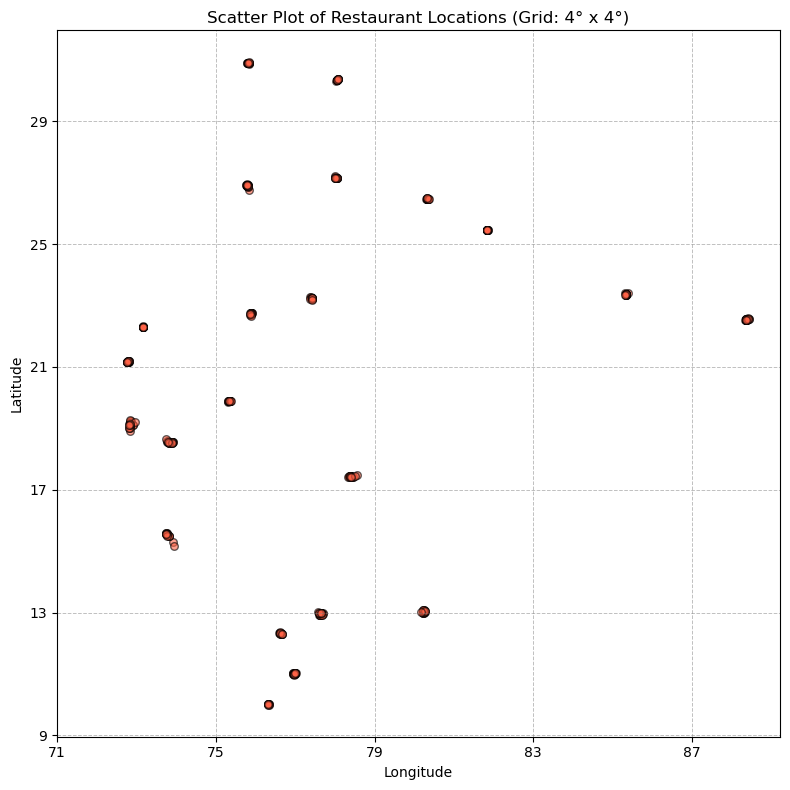

In [29]:
# Create the figure
plt.figure(figsize=(8, 8))

# Scatter plot of restaurant locations
plt.scatter(df2['restaurant_longitude'], df2['restaurant_latitude'],
            alpha=0.6, edgecolor='black', color='tomato', s=30)

# Set axis labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Scatter Plot of Restaurant Locations (Grid: 4° x 4°)')

# Define grid spacing
lon_min, lon_max = df2['restaurant_longitude'].min(), df2['restaurant_longitude'].max()
lat_min, lat_max = df2['restaurant_latitude'].min(), df2['restaurant_latitude'].max()

# Set ticks for every 4 degrees
plt.xticks(range(int(lon_min)-1, int(lon_max)+2, 4))
plt.yticks(range(int(lat_min)-1, int(lat_max)+2, 4))

# Add vertical and horizontal gridlines at every 4 degrees
for x in range(int(lon_min)-1, int(lon_max)+2, 4):
    plt.axvline(x=x, color='gray', linestyle='--', linewidth=0.7, alpha=0.5)
for y in range(int(lat_min)-1, int(lat_max)+2, 4):
    plt.axhline(y=y, color='gray', linestyle='--', linewidth=0.7, alpha=0.5)

# Add custom grid
plt.grid(False)
plt.tight_layout()
plt.show()


In [30]:
# Load your dataset
coords = df2[['restaurant_latitude', 'restaurant_longitude']].values

# Haversine distance function returns distance in kilometers
def haversine_distance_matrix(locations):
    n = len(locations)
    matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            matrix[i, j] = haversine(locations[i], locations[j], unit=Unit.KILOMETERS)
    return matrix

# Step 1: Convert lat/lon to radians for DBSCAN with haversine
coords_radians = np.radians(coords)

# Step 2: Run DBSCAN clustering
# 30 km radius city ⇒ epsilon = 30 km (converted to radians)
kms_per_radian = 6371.0088
epsilon = 30 / kms_per_radian  # radius in radians

db = DBSCAN(eps=epsilon, min_samples=5, algorithm='ball_tree', metric='haversine').fit(coords_radians)
df2['city_label'] = db.labels_  # -1 means noise

# Step 3: Preview city-labeled data
print(df2[['restaurant_latitude', 'restaurant_longitude', 'city_label']].head())

# Optional: Save labeled data
df2.to_csv("zomato_with_city_labels.csv", index=False)


   restaurant_latitude  restaurant_longitude  city_label
0            25.449659             81.839744           0
1            19.880256             75.323503           1
2            19.879631             75.323403           1
3            30.892860             75.822199           2
4            22.538999             88.322337           3


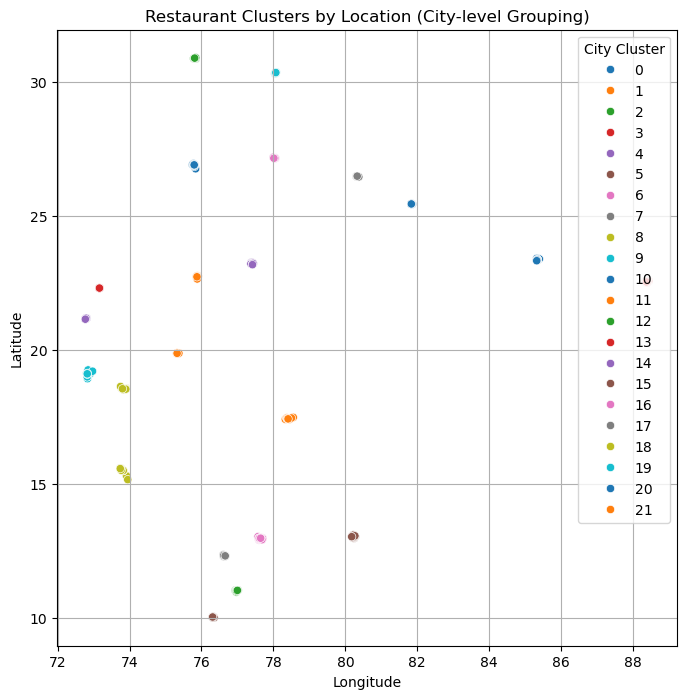

In [31]:
# Basic scatter plot with clusters
plt.figure(figsize=(8, 8))
sborn.scatterplot(
    data=df2,
    x='restaurant_longitude',
    y='restaurant_latitude',
    hue='city_label',
    palette='tab10',
    legend='full'
)
plt.title("Restaurant Clusters by Location (City-level Grouping)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title='City Cluster')
plt.grid(True)
plt.show()


### Setting up cache with Geolocation

In [32]:
# Load or initialize cache
if os.path.exists("geocoding_cache.json"):
    with open("geocoding_cache.json", "r") as f:
        geocoding_cache = json.load(f)
else:
    geocoding_cache = {}

# Compute cluster centers using median
cluster_centers = df2.groupby('city_label')[['restaurant_latitude', 'restaurant_longitude']].median().reset_index()

# Initialize geolocator
geolocator = Nominatim(user_agent="geoapi")

def fun_coord_key(lat, lon):
    return f"{round(lat, 5)},{round(lon, 5)}"

def get_city_name_with_fallback(cluster_label, lat, lon, df_clustered):
    key = fun_coord_key(lat, lon)
    
    # Return from cache if available
    if key in geocoding_cache:
        print(f"[CACHE HIT] {key} → {geocoding_cache[key]}")
        return geocoding_cache[key]
    
    print(f"[CACHE MISS] {key} → making API call...")
    
    # Try reverse geocoding on center
    try:
        location = geolocator.reverse((lat, lon), exactly_one=True, timeout=10)
        if location and 'address' in location.raw:
            city = location.raw['address'].get('city') or \
                   location.raw['address'].get('town') or \
                   location.raw['address'].get('state')
            if city:
                geocoding_cache[key] = city
                return city
    except Exception as e:
        print(f"[ERROR] Reverse geocoding failed for center: {e}")
    
    # Fallback: iterate through other coordinates in the cluster
    group = df_clustered[df_clustered['city_label'] == cluster_label]
    for _, row in group.iterrows():
        coord_key = fun_coord_key(row['restaurant_latitude'], row['restaurant_longitude'])
        if coord_key in geocoding_cache:
            return geocoding_cache[coord_key]
        try:
            location = geolocator.reverse(
                (row['restaurant_latitude'], row['restaurant_longitude']),
                exactly_one=True,
                timeout=10
            )
            if location and 'address' in location.raw:
                city = location.raw['address'].get('city') or \
                       location.raw['address'].get('town')
                if city:
                    geocoding_cache[coord_key] = city
                    return city
        except Exception as e:
            print(f"[FALLBACK ERROR] {coord_key}: {e}")
        time.sleep(1)  # Respect API limits
    
    geocoding_cache[key] = "Unknown"
    return "Unknown"

# Apply the function to cluster centers
cluster_centers['city_name'] = cluster_centers.apply(
    lambda row: get_city_name_with_fallback(
        cluster_label=row['city_label'],
        lat=row['restaurant_latitude'],
        lon=row['restaurant_longitude'],
        df_clustered=df2
    ),
    axis=1
)

with open("geocoding_cache.json", "w") as f:
    json.dump(geocoding_cache, f, indent=2)

# Drop city_name if it exists in df2
if 'city_name' in df2.columns:
    df2 = df2.drop(columns=['city_name'])

# Then merge
df2 = df2.merge(
    cluster_centers[['city_label', 'city_name']],
    on='city_label',
    how='left'
)

[CACHE HIT] 25.45165,81.8345 → Prayagraj
[CACHE HIT] 19.87601,75.3434 → Chhatrapati Sambhaji Nagar
[CACHE HIT] 30.89324,75.82183 → Ludhiana
[CACHE HIT] 22.53906,88.36519 → Kolkata
[CACHE HIT] 23.23245,77.42462 → Bhopal
[CACHE HIT] 10.02385,76.31033 → Ernakulam
[CACHE HIT] 27.16168,78.03744 → Agra
[CACHE HIT] 26.47637,80.32082 → Kanpur
[CACHE HIT] 15.54442,73.76667 → Calangute
[CACHE HIT] 30.34251,78.06119 → Dehradun
[CACHE HIT] 26.90524,75.79594 → Jaipur
[CACHE HIT] 17.43157,78.39911 → Hyderabad
[CACHE HIT] 11.00951,76.97638 → Coimbatore
[CACHE HIT] 22.31094,73.16777 → Vadodara
[CACHE HIT] 21.17093,72.78989 → Gujarat
[CACHE HIT] 13.03724,80.24235 → Chennai
[CACHE HIT] 12.96008,77.63324 → Bengaluru
[CACHE HIT] 12.32319,76.62796 → Mysuru
[CACHE HIT] 18.54494,73.84048 → Pune City
[CACHE HIT] 19.12104,72.83435 → Mumbai Suburban
[CACHE HIT] 23.35911,85.32559 → Ranchi
[CACHE HIT] 22.74529,75.88857 → Indore


In [33]:
print(f"Loaded {len(geocoding_cache)} cached coordinates.")

Loaded 24 cached coordinates.


### Map visualization

In [34]:
import folium

# Step 1: Cluster summary
cluster_stats = df2.groupby('city_name').agg({
    'restaurant_latitude': 'median',
    'restaurant_longitude': 'median',
    'restaurant_id': pd.Series.nunique
}).reset_index().rename(columns={'restaurant_id': 'restaurant_count'})

# Step 2: Base map centered over India
fmap = folium.Map(
    location=[
        cluster_stats['restaurant_latitude'].mean(),
        cluster_stats['restaurant_longitude'].mean()
    ],
    zoom_start=5,
    tiles='CartoDB Positron'  # Cleaner look
)

# Step 3: Plot circles
for _, row in cluster_stats.iterrows():
    lat = row['restaurant_latitude']
    lon = row['restaurant_longitude']
    city = row['city_name']
    count = row['restaurant_count']

    radius = 12000 * np.sqrt(count)
    font_size = min(108, 10 + int(np.sqrt(count)))  # Cap max size for clarity

    # Circle for the cluster
    folium.Circle(
        location=[lat, lon],
        radius=radius,
        color='Green',
        fill=True,
        fill_opacity=0.4
    ).add_to(fmap)

    # Label: restaurant count (center of circle)
    folium.Marker(
        location=[lat, lon],
        icon=folium.DivIcon(html=f"""
            <div style="text-align: center;">
                <span style="
                    font-size: {font_size}px;
                    font-weight: bold;
                    color: black;
                    line-height: 1;
                ">{count}</span>
            </div>
        """)
    ).add_to(fmap)

    # Label: city name (below circle)
    folium.Marker(
        location=[lat - 0.1 * np.sqrt(count), lon],  # shift slightly downward (tweak 0.2 as needed)
        icon=folium.DivIcon(html=f"""
            <div style="text-align: center;">
                <span style="
                    font-size: {font_size - 2}px;
                    font-weight: normal;
                    color: grey;
                ">{city}</span>
            </div>
        """)
    ).add_to(fmap)



# Step 4: Save or display
fmap.save("zomato_clusters_folium.html")

# If in notebook:
from IPython.display import IFrame
IFrame("zomato_clusters_folium.html", width=900, height=600)


## Pattern analysis

In [ ]:
### Cleaning up utilized columns in order to keep data table limited
unwanted_cols = ['time_ordered','time_order_picked']
df.drop(unwanted_cols, inplace=True, axis=1)

### derive distance between restaurant & delivery location ###
dist = []

for idx, row in df.iterrows():
    d = get_distance(row['restaurant_latitude'], row['restaurant_longitude'], row['delivery_location_latitude'], row['delivery_location_longitude'])
    dist.append(d)
    
df['delivery_dist_km'] = dist

unwanted_cols = ['restaurant_latitude','restaurant_longitude', 'delivery_location_latitude', 'delivery_location_longitude']
df.drop(unwanted_cols, inplace=True, axis=1)

df.reset_index(drop=True, inplace=True)

In [ ]:
rating_variation = df.groupby('delivery_person_id')['delivery_person_ratings'].nunique()

# Find delivery persons with more than one unique rating
inconsistent_ratings = rating_variation[rating_variation > 1]

print(f"Number of delivery persons with varying ratings: {len(inconsistent_ratings)}")

consistent_ratings = rating_variation[rating_variation == 1]
print(f"Number of delivery persons with same ratings: {len(consistent_ratings)}")

# renaming the delivery_person_ratings column appropriately
df.rename(columns={'delivery_person_ratings': 'delivery_satisfaction_rating'}, inplace=True)
